# 📋 ATML PA4 - Task 2: Implementing FedAvg

In this task, we will implement the **Federated Averaging (FedAvg)** algorithm as described in the assignment manual. We will use our core `federated_learning.py` framework to conduct two main experiments on the CIFAR-10 dataset:

1.  **Varying Local Epochs (K):** We'll analyze the trade-off between local computation (increasing `K`) and communication frequency.
2.  **Varying Client Sampling (f):** We'll study the impact of partial client participation on convergence and stability.

We will track global test accuracy and average client drift to analyze the performance of FedAvg under these different conditions.

---

## **Part 1: Environment Setup**

### **1.1. Imports and Configuration**

First, we import all necessary libraries. This includes `torch`, `matplotlib`, and, most importantly, our `federated_train` function from the `federated_learning.py` file. We also set up our device (preferring CUDA) and create a directory for our plots.

In [1]:
# ============================================
# 📦 Imports and Environment Setup
# ============================================
import json
import sys
import os
import torch
import matplotlib.pyplot as plt

# Add the parent directory to the path to find our module
sys.path.append('.') 

# Import the main training function from our .py file
from federated_learning import federated_train

# Ensure plots appear in the notebook
%matplotlib inline

# ============================================
# ⚙️ Configuration
# ============================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# --- Define Directories ---
PLOT_DIR = 'plots'
JSON_DIR = 'json_results'
PTH_DIR = 'pth_models'

# --- Create Directories ---
for dir_path in [PLOT_DIR, JSON_DIR, PTH_DIR]:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print(f"Created directory: {dir_path}")

# Global experiment parameters
NUM_CLIENTS = 10
NUM_ROUNDS = 50
LEARNING_RATE = 0.01
BATCH_SIZE = 32
SEED = 42

# ============================================
# 🔁 Set to True to re-run training, False to load from files
# ============================================
FORCE_RETRAIN = False 
print(f"FORCE_RETRAIN set to: {FORCE_RETRAIN}")

Using device: cuda
GPU: NVIDIA RTX PRO 6000 Blackwell Workstation Edition
FORCE_RETRAIN set to: False


---

## **Part 2: Experiment 1 - Varying Local Epochs (K)**

### **2.1. Running the Experiment**

We will now run the first experiment. We test `K` values of `{1, 5, 10, 20}`. For this experiment, all clients participate in every round (`client_fraction = 1.0`). We'll store the results in a dictionary for later plotting.

In [2]:
# ============================================
# 🚀 Experiment 1: Varying K
# ============================================
K_values = [1, 5, 10, 20]
results_K = {}
RESULTS_FILE_K = os.path.join(JSON_DIR, 'task2_results_K.json')

if os.path.exists(RESULTS_FILE_K) and not FORCE_RETRAIN:
    print(f"Loading K-results from {RESULTS_FILE_K}...")
    with open(RESULTS_FILE_K, 'r') as f:
        results_K = json.load(f)
    print("Results loaded.")

else:
    if FORCE_RETRAIN:
        print("FORCE_RETRAIN is True. Re-running Experiment 1...")
    else:
        print("No results file found. Starting Experiment 1: Varying K...")

    for K in K_values:
        print(f"\n{'='*70}")
        print(f"🔥 Training with K={K} local epochs")
        print(f"{'='*70}")
        
        # Unpack both model and history
        model, history = federated_train(
            num_clients=NUM_CLIENTS,
            num_rounds=NUM_ROUNDS,
            local_epochs=K,
            client_fraction=1.0,  # All clients participate
            lr=LEARNING_RATE,
            batch_size=BATCH_SIZE,
            device=device,
            seed=SEED
        )
        results_K[f'K={K}'] = history
        
        # Save the final model state
        MODEL_SAVE_PATH = os.path.join(PTH_DIR, f"task2_model_K={K}.pth")
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"Saved model to {MODEL_SAVE_PATH}")

    print("\nExperiment 1 Complete.")
    
    # Save the results dictionary
    with open(RESULTS_FILE_K, 'w') as f:
        json.dump(results_K, f, indent=4)
    print(f"Saved K-value results to {RESULTS_FILE_K}")

Loading K-results from json_results/task2_results_K.json...
Results loaded.


### **2.2. Plotting Results (Experiment 1)**

Now we plot two figures:
1.  **Test Accuracy vs. Rounds:** Shows how fast the global model converges.
2.  **Client Drift vs. Rounds:** Shows the average L2 norm distance between client models and the global model.

We expect that higher `K` will show faster initial accuracy gains but also exhibit higher client drift, which can lead to instability.

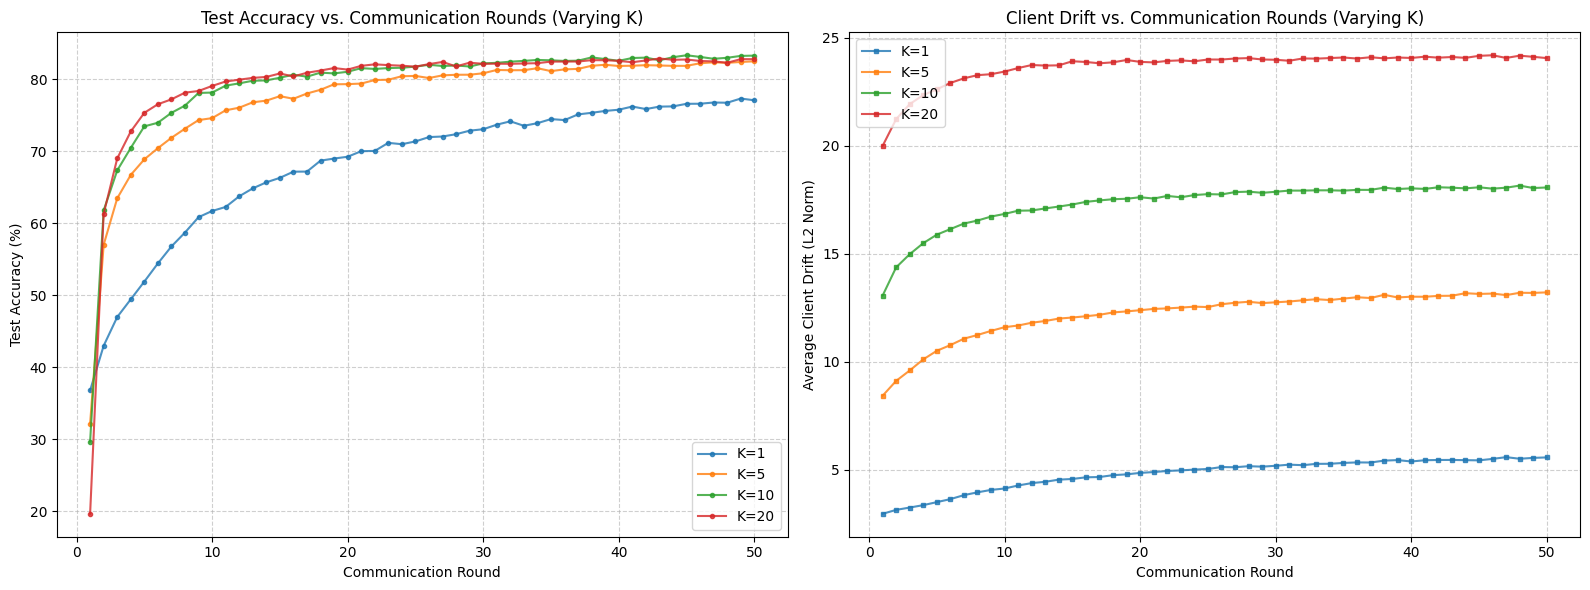

In [3]:
# ============================================
# 📊 Plotting Experiment 1
# ============================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Plot 1: Test Accuracy ---
axes[0].set_title('Test Accuracy vs. Communication Rounds (Varying K)')
axes[0].set_xlabel('Communication Round')
axes[0].set_ylabel('Test Accuracy (%)')
for label, history in results_K.items():
    axes[0].plot(history['rounds'], history['test_acc'], label=label, marker='o', markersize=3, alpha=0.8)
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

# --- Plot 2: Client Drift ---
axes[1].set_title('Client Drift vs. Communication Rounds (Varying K)')
axes[1].set_xlabel('Communication Round')
axes[1].set_ylabel('Average Client Drift (L2 Norm)')
for label, history in results_K.items():
    axes[1].plot(history['rounds'], history['client_drift'], label=label, marker='s', markersize=3, alpha=0.8)
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)

# --- Save and Show ---
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, 'task2_varying_K.png'), dpi=300)
plt.show()

---

## **Part 3: Experiment 2 - Varying Client Sampling (f)**

### **3.1. Running the Experiment**

Now we run the second experiment, varying the client sampling fraction `f`. We will test `f` values of `{1.0, 0.5, 0.2}`. For this experiment, we keep the number of local epochs fixed at `K=5` to isolate the effect of partial participation.

In [4]:
# ============================================
# 🚀 Experiment 2: Varying Client Fraction (f)
# ============================================
fractions = [1.0, 0.5, 0.2]
results_sampling = {}
RESULTS_FILE_F = os.path.join(JSON_DIR, 'task2_results_sampling.json')

if os.path.exists(RESULTS_FILE_F) and not FORCE_RETRAIN:
    print(f"Loading F-results from {RESULTS_FILE_F}...")
    with open(RESULTS_FILE_F, 'r') as f:
        results_sampling = json.load(f)
    print("Results loaded.")

else:
    if FORCE_RETRAIN:
        print("FORCE_RETRAIN is True. Re-running Experiment 2...")
    else:
        print("No results file found. Starting Experiment 2: Varying Client Fraction...")

    for f in fractions:
        print(f"\n{'='*70}")
        print(f"🔥 Training with f={f*100:.0f}% client participation")
        print(f"{'='*70}")
        
        # Unpack both model and history
        model, history = federated_train(
            num_clients=NUM_CLIENTS,
            num_rounds=NUM_ROUNDS,
            local_epochs=5,  # Fixed K=5
            client_fraction=f,
            lr=LEARNING_RATE,
            batch_size=BATCH_SIZE,
            device=device,
            seed=SEED
        )
        results_sampling[f'fraction={f}'] = history
        
        # Save the final model state
        MODEL_SAVE_PATH = os.path.join(PTH_DIR, f"task2_model_F={f}.pth")
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"Saved model to {MODEL_SAVE_PATH}")

    print("\nExperiment 2 Complete.")
    
    # Save the results dictionary
    with open(RESULTS_FILE_F, 'w') as f:
        json.dump(results_sampling, f, indent=4)
    print(f"Saved sampling-value results to {RESULTS_FILE_F}")

Loading F-results from json_results/task2_results_sampling.json...
Results loaded.


### **3.2. Plotting Results (Experiment 2)**

We plot the same metrics as before.

We expect that a lower sampling fraction (e.g., `f=0.2`) will result in slower convergence and potentially more oscillation, as the global model aggregation is based on a smaller, potentially less representative, subset of clients each round.

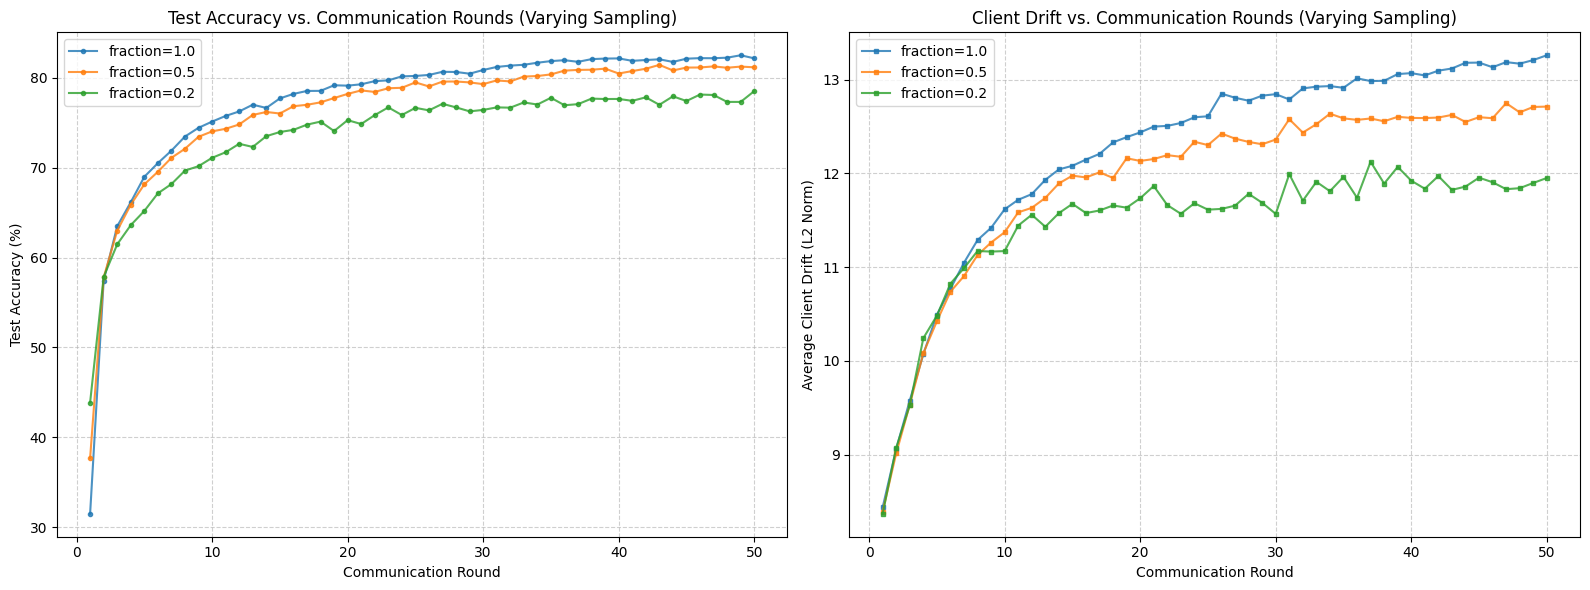

In [5]:
# ============================================
# 📊 Plotting Experiment 2
# ============================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Plot 1: Test Accuracy ---
axes[0].set_title('Test Accuracy vs. Communication Rounds (Varying Sampling)')
axes[0].set_xlabel('Communication Round')
axes[0].set_ylabel('Test Accuracy (%)')
for label, history in results_sampling.items():
    axes[0].plot(history['rounds'], history['test_acc'], label=label, marker='o', markersize=3, alpha=0.8)
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

# --- Plot 2: Client Drift ---
axes[1].set_title('Client Drift vs. Communication Rounds (Varying Sampling)')
axes[1].set_xlabel('Communication Round')
axes[1].set_ylabel('Average Client Drift (L2 Norm)')
for label, history in results_sampling.items():
    axes[1].plot(history['rounds'], history['client_drift'], label=label, marker='s', markersize=3, alpha=0.8)
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)

# --- Save and Show ---
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, 'task2_client_sampling.png'), dpi=300)
plt.show()